<a href="https://colab.research.google.com/github/MertYuksek/Differentiate-Simpsons/blob/main/simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Canaro a Python library including support for Deep Learning models built using the Keras framework.
# Keras is a high-level neural network library that runs on top of TensorFlow.
! pip install canaro caer

# Import Library


In [2]:
import caer
import canaro
import os
import numpy as np
import cv2 as cv
import gc

# Kaggle Set Up

In [ ]:
# Firstly adding kaggle.json file to files sections. Then;

# 1. Install the Kaggle library
! pip install kaggle

In [4]:
# 2. Make a directory named “.kaggle”
! mkdir ~/.kaggle

In [5]:
# 3. Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [6]:
# 4. Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

# Get Dataset From Kaggle

In [ ]:
# We are now ready to download datasets from Kaggle.

# We will get a zip folder.
! kaggle datasets download alexattia/the-simpsons-characters-dataset

# Unzip this folder
! unzip the-simpsons-characters-dataset

# Data Pre Processing

In [ ]:
# Computer vision model expects all image data to be same size.
IMG_SIZE = (80,80)
# Color channels, for this problem we don't need colors. So we set grayscale.
channels = 1 
base_path = r'/content/simpsons_dataset'

character_dict = {}
for character in os.listdir(base_path):
  character_dict[character] = len(os.listdir(os.path.join(base_path,character)))

character_dict = caer.sort_dict(character_dict, descending=True)
character_dict

In [9]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in character_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [ ]:
# Create the training data
train = caer.preprocess_from_dir(base_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

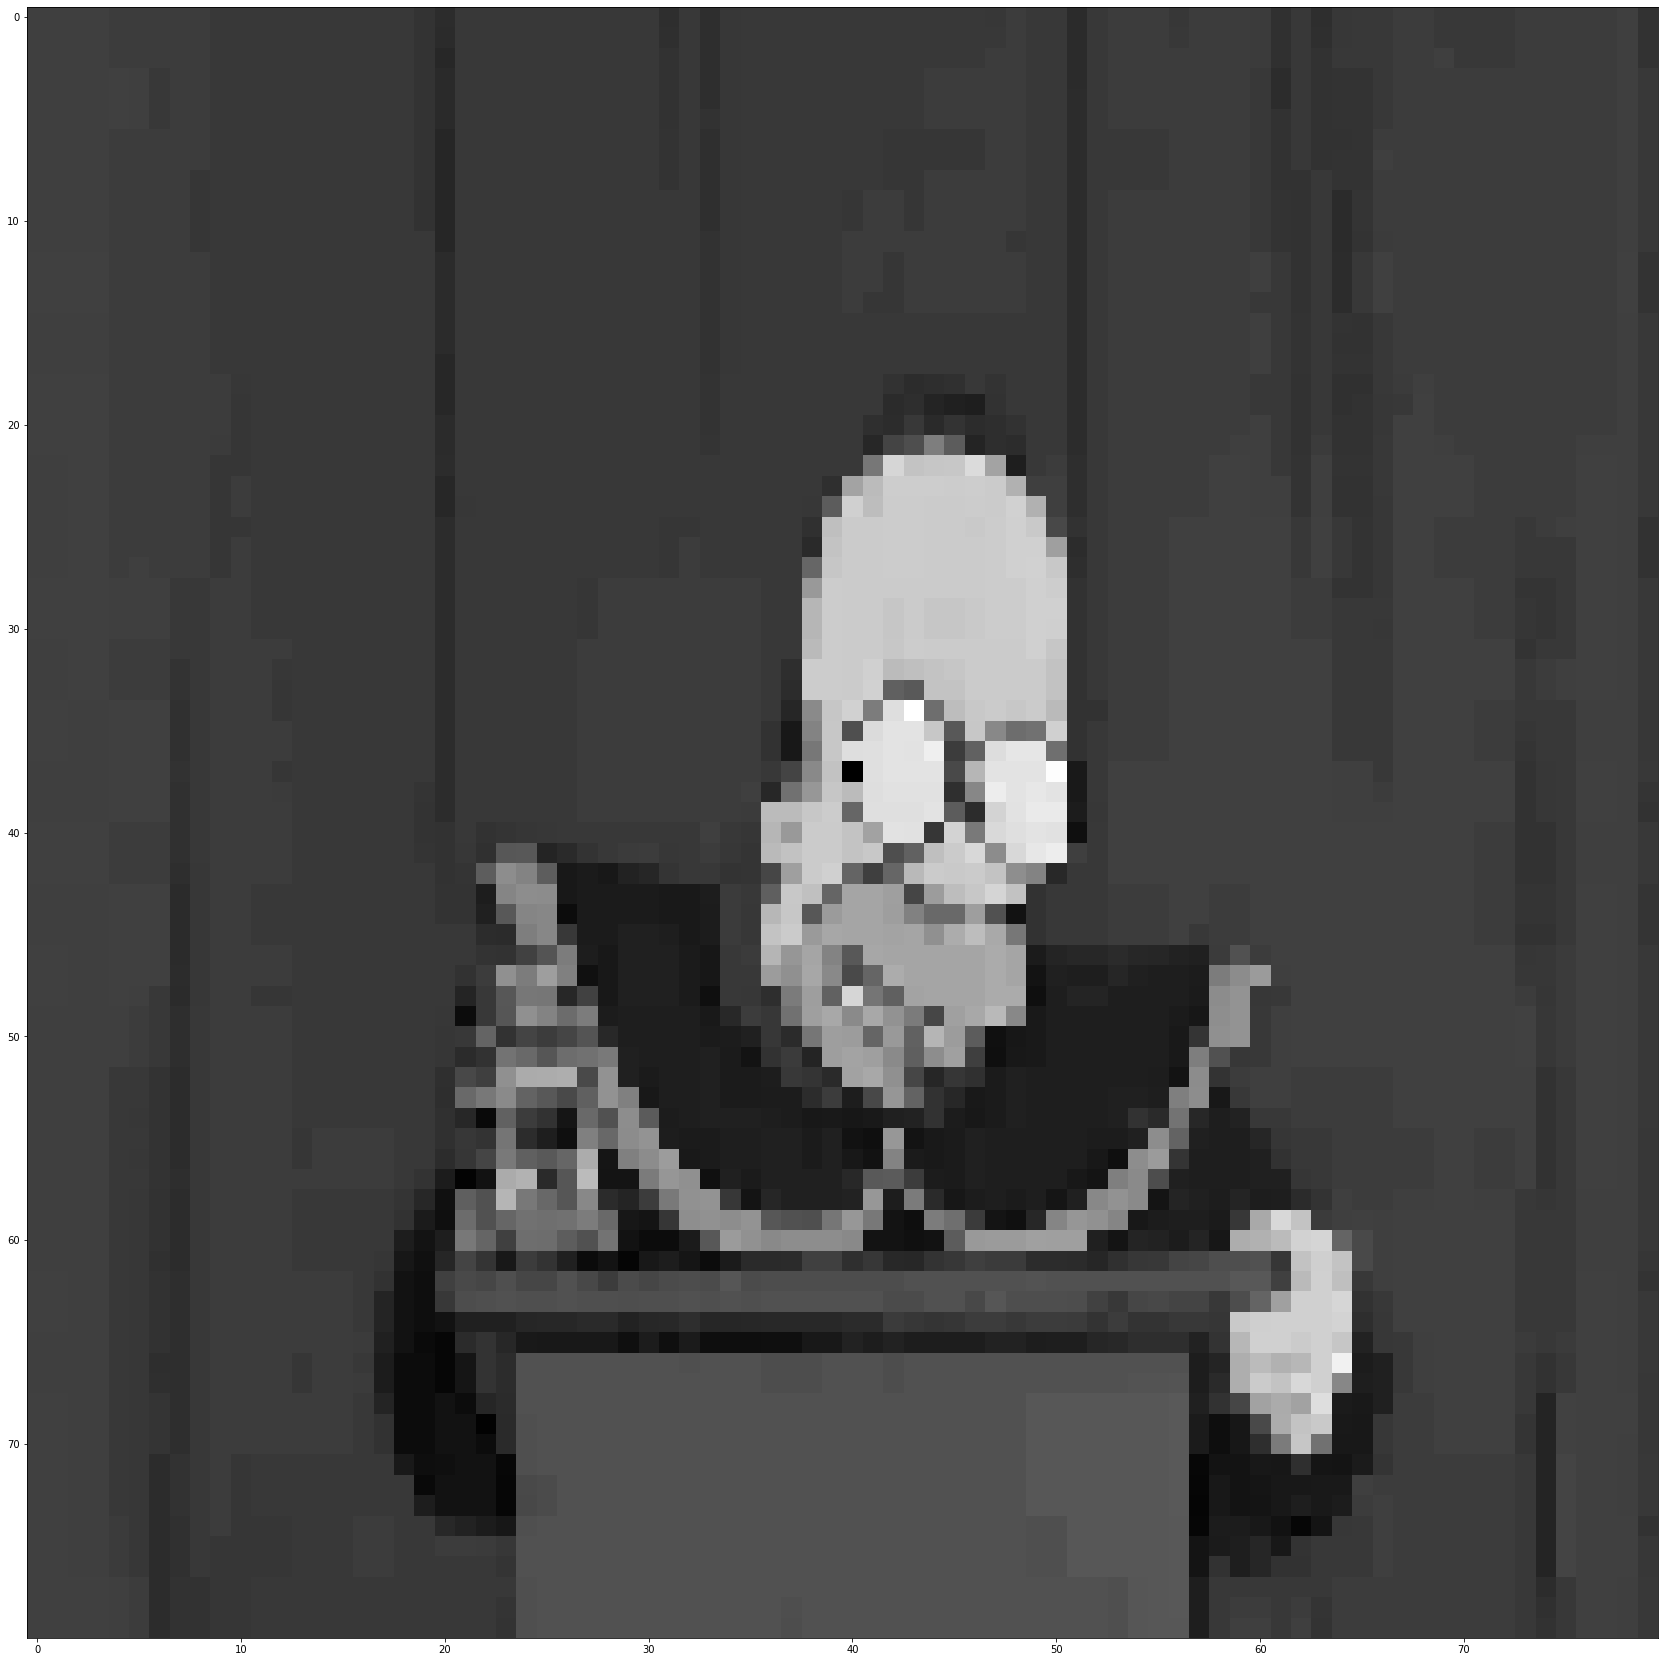

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[3][0], cmap='gray')
plt.show()

In [12]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [13]:
# Normalize the feature set (0,1)
featureSet = caer.normalize(featureSet)

from tensorflow.keras.utils import  to_categorical
print(len(labels))
print(labels.shape)
print(labels[0])
# One Hot Encoding
labels = to_categorical(labels, len(characters))
print(len(labels))
print(labels)
print(labels[0])

13811
(13811,)
6
13811
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [14]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [15]:
# delete unnecessary object
del train
del featureSet
del labels
gc.collect()

50

In [16]:
BATCH_SIZE = 32
EPOCHS = 10

datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

# Create Model

In [17]:
# Create our model (returns a compiled model)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 80, 80, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 39, 39, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 64)        36928     
                                                      

In [22]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit_generator(train_gen,
                    #steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
346/346 [==============================] - 22s 64ms/step - loss: 0.2167 - accuracy: 0.5365 - val_loss: 0.2006 - val_accuracy: 0.5941 - lr: 0.0100
Epoch 2/10
346/346 [==============================] - 19s 56ms/step - loss: 0.2121 - accuracy: 0.5485 - lr: 0.0100
Epoch 3/10
346/346 [==============================] - 19s 55ms/step - loss: 0.2086 - accuracy: 0.5577 - lr: 0.0100
Epoch 4/10
346/346 [==============================] - 19s 56ms/step - loss: 0.2026 - accuracy: 0.5778 - lr: 0.0100
Epoch 5/10
346/346 [==============================] - 19s 56ms/step - loss: 0.1975 - accuracy: 0.5867 - lr: 0.0100
Epoch 6/10
346/346 [==============================] - 19s 56ms/step - loss: 0.1938 - accuracy: 0.5947 - lr: 0.0100
Epoch 7/10
346/346 [==============================] - 19s 55ms/step - loss: 0.1893 - accuracy: 0.6066 - lr: 0.0100
Epoch 8/10
346/346 [==============================] - 19s 55ms/step - loss: 0.1863 - accuracy: 0.6135 - lr: 0.0100
Epoch 9/10
346/346 [==================